In [1]:
from pprint import pprint
import time
import requests
import pandas as pd
from config import rapidapi_key
import datetime
import matplotlib.pyplot as plt

## Italy Index

In [2]:
italy_df = pd.read_csv("italy_index/FTSE Italia All Share Historical Data.csv")
italy_df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 20, 2020","17,171.55","17,209.93","17,628.87","17,047.73",1.50B,1.85%
1,"Mar 19, 2020","16,859.82","16,814.38","17,240.13","16,438.49",1.27B,2.27%
2,"Mar 18, 2020","16,486.21","16,372.27","16,785.57","16,149.48",992.76M,-1.17%
3,"Mar 17, 2020","16,680.56","16,850.34","17,238.59","16,065.72",1.40B,1.96%
4,"Mar 16, 2020","16,360.04","17,130.96","17,130.96","15,498.19",1.54B,-6.06%


## S&P 500

In [2]:
curr_time = int(time.time())
prior_year = curr_time-(60*60*24*365)
ticker_symbol = "^GSPC"

In [3]:
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response = requests.request("GET", url, headers=headers, params=querystring)


In [4]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

smpDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
smp_df = pd.DataFrame(smpDict)
smp_df

,Timestamp,Open,Close,Volume,Adjclose
0,1553261400,2844.520020,2800.709961,4237200000,2800.709961
1,1553520600,2796.010010,2798.360107,3376580000,2798.360107
2,1553607000,2812.659912,2818.459961,3266050000,2818.459961
3,1553693400,2819.719971,2805.370117,3372930000,2805.370117
4,1553779800,2809.399902,2815.439941,3158170000,2815.439941
...,...,...,...,...,...
247,1584365400,2508.590088,2386.129883,7781540000,2386.129883
248,1584451800,2425.659912,2529.189941,8358500000,2529.189941
249,1584538200,2436.500000,2398.100098,8755780000,2398.100098
250,1584624600,2393.479980,2409.389893,7946710000,2409.389893


## SSE Composite Index

In [5]:
ticker_symbol = "^SSEC"

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response2 = requests.request("GET", url, headers=headers, params=querystring)


In [6]:
timestamp = response2.json()['chart']['result'][0]['timestamp']
year_close = response2.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response2.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response2.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response2.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

sseDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
sse_df = pd.DataFrame(smpDict)
sse_df

,Timestamp,Open,Close,Volume,Adjclose
0,1553261400,2844.520020,2800.709961,4237200000,2800.709961
1,1553520600,2796.010010,2798.360107,3376580000,2798.360107
2,1553607000,2812.659912,2818.459961,3266050000,2818.459961
3,1553693400,2819.719971,2805.370117,3372930000,2805.370117
4,1553779800,2809.399902,2815.439941,3158170000,2815.439941
...,...,...,...,...,...
247,1584365400,2508.590088,2386.129883,7781540000,2386.129883
248,1584451800,2425.659912,2529.189941,8358500000,2529.189941
249,1584538200,2436.500000,2398.100098,8755780000,2398.100098
250,1584624600,2393.479980,2409.389893,7946710000,2409.389893


## Dow Jones Industrial Average 

In [7]:
ticker_symbol = "^SSEC"

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': rapidapi_key
    }

response3 = requests.request("GET", url, headers=headers, params=querystring)


In [8]:
timestamp = response3.json()['chart']['result'][0]['timestamp']
year_close = response3.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response3.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response3.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response3.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

djiDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
dji_df = pd.DataFrame(smpDict)
dji_df

,Timestamp,Open,Close,Volume,Adjclose
0,1553261400,2844.520020,2800.709961,4237200000,2800.709961
1,1553520600,2796.010010,2798.360107,3376580000,2798.360107
2,1553607000,2812.659912,2818.459961,3266050000,2818.459961
3,1553693400,2819.719971,2805.370117,3372930000,2805.370117
4,1553779800,2809.399902,2815.439941,3158170000,2815.439941
...,...,...,...,...,...
247,1584365400,2508.590088,2386.129883,7781540000,2386.129883
248,1584451800,2425.659912,2529.189941,8358500000,2529.189941
249,1584538200,2436.500000,2398.100098,8755780000,2398.100098
250,1584624600,2393.479980,2409.389893,7946710000,2409.389893


## Covid19 Data

In [14]:
time_series_2019_ncov_Deaths =pd.read_csv("covid19_data/time_series_2019-ncov-Deaths.csv")
time_series_2019_ncov_Recovered = pd.read_csv("covid19_data/time_series_2019-ncov-Recovered.csv")
time_series_ncov_Confirmed = pd.read_csv("covid19_data/time_series-ncov-Confirmed.csv")
time_series_ncov_Deaths = pd.read_csv("covid19_data/time_series-ncov-Deaths.csv")
time_series_2019_ncov_Confirmed = pd.read_csv("covid19_data/time_series_2019-ncov-Confirmed.csv")
time_series_2019_ncov_Recovered = pd.read_csv("covid19_data/time_series_2019-ncov-Recovered.csv")




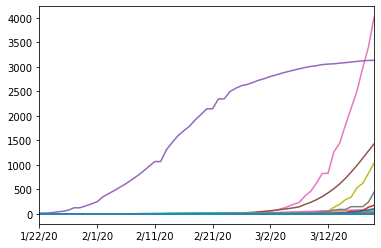

In [67]:
t = time_series_2019_ncov_Deaths
t =t.drop(columns =['Lat','Long','Province/State'])
t =t.set_index('Country/Region')
t =t.T
t.plot(legend=False)
plt.show()

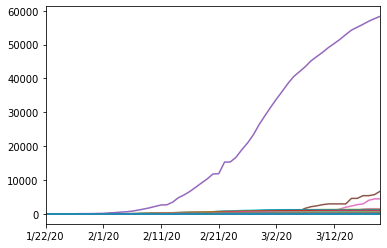

In [66]:
t = time_series_2019_ncov_Recovered
t =t.drop(columns =['Lat','Long','Province/State'])
t =t.set_index('Country/Region')
t =t.T
t.plot(legend=False)
plt.show()

In [64]:
time_series_ncov_Confirmed.head()

#t = time_series_ncov_Confirmed
#t =t.drop(columns =['Lat','Long','Province/State'])
#t =t.set_index('Country/Region')
#t =t.T
#t.plot(legend=False)
#plt.show()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+infected+value+num
1,NaN,Afghanistan,33.0,65.0,2020-03-20,24
2,NaN,Afghanistan,33.0,65.0,2020-03-19,22
3,NaN,Afghanistan,33.0,65.0,2020-03-18,22
4,NaN,Afghanistan,33.0,65.0,2020-03-17,22


In [65]:
time_series_ncov_Deaths.head()

#t = time_series_ncov_Deaths
#t =t.drop(columns =['Lat','Long','Province/State'])
#t =t.set_index('Country/Region')
#t =t.T
#t.plot(legend=False)
#plt.show()

,Province/State,Country/Region,Lat,Long,Date,Value
0,#adm1+name,#country+name,#geo+lat,#geo+lon,#date,#affected+killed+value+num
1,NaN,Afghanistan,33.0,65.0,2020-03-20,0
2,NaN,Afghanistan,33.0,65.0,2020-03-19,0
3,NaN,Afghanistan,33.0,65.0,2020-03-18,0
4,NaN,Afghanistan,33.0,65.0,2020-03-17,0


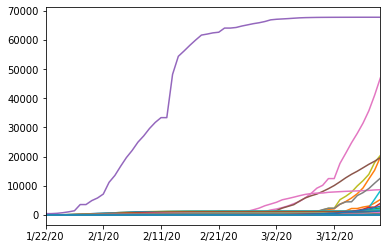

In [58]:
t = time_series_2019_ncov_Confirmed
t =t.drop(columns =['Lat','Long','Province/State'])
t =t.set_index('Country/Region')
t =t.T
t.plot(legend=False)
plt.show()

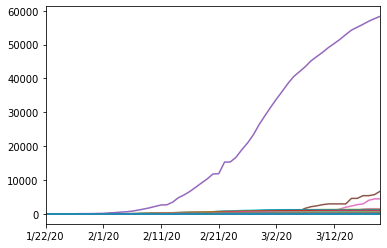

In [57]:
t = time_series_2019_ncov_Recovered
t =t.drop(columns =['Lat','Long','Province/State'])
t =t.set_index('Country/Region')
t =t.T
t.plot(legend=False)
plt.show()